<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [2]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# 前処理をまとめる
transform = transforms.Compose([
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:04<00:00, 40.7MB/s]


In [4]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [5]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [6]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [7]:
# 損失関数とoptimizerを設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。

In [8]:
# 学習のループ
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # 勾配の初期化
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.3945951851147989, acc: 0.49418187141418457,      val loss: 1.051120424422974, val acc: 0.6330870389938354
epoch: 1, loss: 0.9278238766557958, acc: 0.672144889831543,      val loss: 0.8590387627720452, val acc: 0.6999800205230713
epoch: 2, loss: 0.7486819629000305, acc: 0.7380038499832153,      val loss: 0.7863769222753116, val acc: 0.7247403860092163
epoch: 3, loss: 0.6464127854075252, acc: 0.7734924554824829,      val loss: 0.769812136888504, val acc: 0.7343250513076782
epoch: 4, loss: 0.5712354901465405, acc: 0.7991243004798889,      val loss: 0.7669448320286724, val acc: 0.7414137125015259
epoch: 5, loss: 0.509744665982894, acc: 0.8247360587120056,      val loss: 0.709970901235224, val acc: 0.7596845030784607
epoch: 6, loss: 0.4577311668175577, acc: 0.8408709168434143,      val loss: 0.7178539333823389, val acc: 0.7544928193092346
epoch: 7, loss: 0.4122376621808673, acc: 0.8546465039253235,      val loss: 0.7514893830108186, val acc: 0.7670726776123047
epoch: 8, lo

In [13]:
pred

tensor([9, 7, 0, 2, 3, 4, 3, 2, 4, 3, 1, 9, 7, 7, 9, 6], device='cuda:0')

In [17]:
prob = prob_pred[:, 0]

In [19]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([1.8068e-02, 6.0962e-06, 1.0000e+00, 5.0085e-05, 4.2796e-04, 5.1899e-04,
        1.6866e-04, 2.7989e-05, 3.5173e-09, 5.5151e-05, 1.1733e-12, 2.9459e-01,
        1.2936e-04, 2.3364e-10, 1.4343e-08, 1.7919e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

# 評価項目

In [9]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.9132)
tensor(0.7625)
[[4644   17   86   38   32   14   14   21   89   45]
 [  18 4782    8    5    2    9   15    4   46  111]
 [ 122    7 4392  103  121   91   90   46   21    7]
 [  34    7   94 4253   99  291  113   71   26   12]
 [  37    4  119   86 4517   63   61   94    8   11]
 [  22    5  100  318   81 4315   43   94   10   12]
 [  11    8   99   99   57   50 4638    9   16   13]
 [  26    6   52   70   88   85   10 4650    5    8]
 [  86   28   17   31   11    6   16    8 4751   46]
 [  50  115   12   27    6   10   12   13   37 4718]]
[[808  11  45  10  20   7  16  12  47  24]
 [  8 854   9  10   2   4  13   0  29  71]
 [ 43   3 703  32  78  33  78  14  10   6]
 [ 18   5  71 541  76 108 129  34   9   9]
 [ 14   1  76  34 759  18  57  33   7   1]
 [ 12   2  64 143  50 604  84  32   5   4]
 [  4   1  31  27  16   4 912   1   2   2]
 [ 12   2  40  36  79  45  20 749   8   9]
 [ 61  13  10  11   7   3  14   2 865  14]
 [ 26  57  11  13   4   2  13   8  33 833]]
[0.9288 

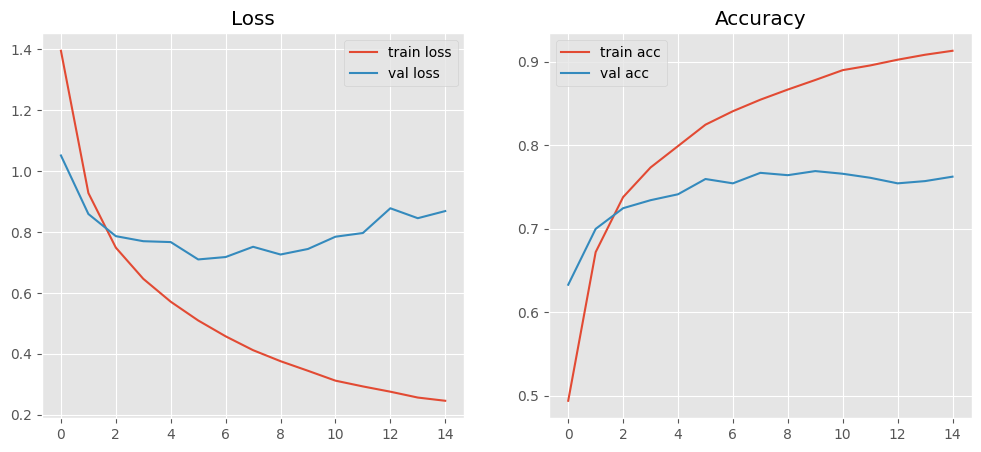

In [10]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [11]:
print(accs)
print(val_accs)

[tensor(0.4942), tensor(0.6721), tensor(0.7380), tensor(0.7735), tensor(0.7991), tensor(0.8247), tensor(0.8409), tensor(0.8546), tensor(0.8668), tensor(0.8782), tensor(0.8900), tensor(0.8956), tensor(0.9025), tensor(0.9084), tensor(0.9132)]
[tensor(0.6331), tensor(0.7000), tensor(0.7247), tensor(0.7343), tensor(0.7414), tensor(0.7597), tensor(0.7545), tensor(0.7671), tensor(0.7643), tensor(0.7692), tensor(0.7660), tensor(0.7612), tensor(0.7545), tensor(0.7572), tensor(0.7625)]
